In [1]:
import numpy as np
import matplotlib.pyplot as plt

C:\Users\rannu\AppData\Local\Temp\ipykernel_21016\3330869017.py:5: RuntimeWarning: invalid value encountered in sqrt
  x_g, y_g = np.meshgrid(x, np.sqrt(1-y))


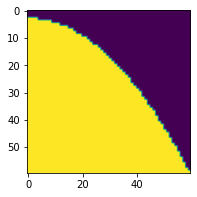

In [16]:
num_points = 60
x = np.linspace(0, 1, num_points)
y = np.linspace(0, 1.05, num_points)

def bool_domain_gen(x, y, num_points):
    x_g, y_g = np.meshgrid(x, np.sqrt(1-y))
    y_g = y_g[::-1]
    bool_domain = x_g <= y_g
    return bool_domain

bool_domain = bool_domain_gen(x, y, num_points)

plt.figure(figsize = (3,3))
plt.imshow(bool_domain)